# Analisis Sentimen Notebook

Melakukan analisis sentimen pada data hasil scraping

## Import Libraries

Import library yang akan digunakan

In [1]:
import os
import re
import pickle
import string
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import *
from indoNLP.preprocessing import *
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

**Configs**

In [2]:
SEED = 2020
color_mapper = ["#B21E58", "#F79647", "#43AD65"] # [Negative, Neutral, Positive]

## Load Dataset

**Loading Sample Data**

Karena untuk melakukan pemodelan memerlukan label (`y`) sedangkan data hasil scraping tidak memiliki label (`y`). Maka perlu dilakukan labeling secara manual dengan ketentuan:

* `0` adalah label untuk tweet yang bersentimen `negatif`
* `1` adalah label untuk tweet yang bersentimen `netral`
* `2` adalah label untuk tweet yang bersentimen `positif`

Karena jika menggunakan seluruh data yang di scraping untuk dilakukan labeling secara manual membutuhkan waktu dan tenaga yang besar (karena jumlah datanya sangat banyak), maka perlu dilakukan sampling terhadap dataset untuk mengambil sebagian data. Pada notebook ini akan digunakan dataset hasil sampling data dan telah dilakukan labeling secara manual, untuk proses samplingnya dapat dilihat pada notebook `Sampling.ipynb`

In [3]:
data = pd.read_csv("../data/Sample Tweet.csv")
data.head()

,tweets,sentiment
0,Salut! Polri mendapat apresiasi dari DPR RI da...,2
1,Sebelum booming corona biasanya ke pasar nongk...,0
2,Covid 19 plus 30 ribu narapidana https://t.co/...,0
3,"@faruqhmd Lu corona ora, muntaber iya.",0
4,3. Jenazah belum dapat dipastikan apakah posit...,1


## Data Preprocessing

Preprocess data text sebelum diolah. Digunakan library [`indoNLP`](https://hyuto.github.io/indo-nlp/) untuk menghandle beberapa proses _text preprocessing_, install library `indoNLP` sebelumnya dengan:

```bash
pip install indoNLP
```

Akan dilakukan beberapa tahap untuk preprocess data text agar siap digunakan, yaitu:

1. Casefolding
2. Menghapus whitespace
3. Menerjemahkan emoji menjadi kata - kata
4. Normalisasi karakter unicode string ke ascii
5. Menghapus HTML dan URL
6. Mengganti word elongation
7. Mengganti kata gaul (slang) ke bentuk yang lebih formal
8. Menghapus tanda baca dan angka
9. Stemming

In [4]:
STEMMER = StemmerFactory().create_stemmer()

def preprocessing(text):
    text = text.lower()
    text = re.sub(r"\s+", " ", text, flags=re.UNICODE)  # remove whitespace
    text = emoji_to_words(text)  # remove emoji
    text = unicodedata.normalize("NFD", text).encode("ascii", "ignore").decode("ascii")
    text = remove_html(text)  # remove html tags
    text = remove_url(text)  # remove url
    text = replace_word_elongation(text)  # replace WE
    text = replace_slang(text)  # replace slang words
    text = text.translate(str.maketrans(string.digits, " " * len(string.digits)))  # remove numbers
    text = text.translate(
        str.maketrans(string.punctuation, " " * len(string.punctuation))
    )  # remove punctuation
    text = " ".join(text.split())
    text = STEMMER.stem(text)
    return " ".join(text.split())

data["cleaned"] = [preprocessing(x) for x in tqdm(data["tweets"].values)]
data.head()

  0%|          | 0/553 [00:00<?, ?it/s]

,tweets,sentiment,cleaned
0,Salut! Polri mendapat apresiasi dari DPR RI da...,2,salut polri dapat apresiasi dari dpr ri dalam ...
1,Sebelum booming corona biasanya ke pasar nongk...,0,belum booming corona biasa ke pasar nongkrong ...
2,Covid 19 plus 30 ribu narapidana https://t.co/...,0,covid plus ribu narapidana
3,"@faruqhmd Lu corona ora, muntaber iya.",0,faruqhmd lu corona ora muntaber iya
4,3. Jenazah belum dapat dipastikan apakah posit...,1,jenazah belum dapat pasti apakah positif infek...


## Pemodelan

**EDA**

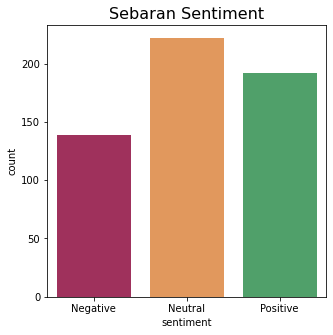

In [5]:
plt.figure(figsize=(5, 5))
sns.countplot(data=data, x="sentiment", palette=color_mapper)
plt.title("Sebaran Sentiment", fontsize=16)
plt.xticks([0, 1, 2], ["Negative", "Neutral", "Positive"])
plt.show()

**Insight**

Dapat dilihat dari grafik diatas bahwa distribusi setiap sentimen pada data sample tidak menunjukkan `imbalance` pada setiap kelasnya, walaupun didominasi oleh sentimen netral tetapi jumlah data setiap sentimen tidak terlalu berbeda jauh.

### Membandingkan Model

Akan dilakukan pemodelan menggunakan beberapa metode machine learning seperti:

1. Decision Tree
2. Logistic Regression
3. Random Forest Classifier
4. Support Vector Machine

Lalu performa model - model tersebut akan dibandingkan dengan melihat metric `accuracy` untuk dipilih sebagai model terbaik. Akan dilakukan fitting model - model dengan menggunakan `StratifiedKfold` sebanyak 5 split lalu model - model tersebut akan diukur keakuratannya dengan menghitung rata - rata akurasinya.

In [6]:
cv = StratifiedKFold(shuffle=True, random_state=SEED)

classifiers = {
    "Decision Tree Classifier ": DecisionTreeClassifier(random_state=SEED),
    "Logistic Regression      ": LogisticRegression(random_state=SEED),
    "Random Forest Classifier ": RandomForestClassifier(random_state=SEED),
    "SVM                      ": SVC(kernel="linear", probability=True, random_state=SEED),
}

for name, clf in classifiers.items():
    pipe = Pipeline([("tf-idf", TfidfVectorizer()), ("clf", clf)])
    scores = cross_val_score(pipe, data["cleaned"].values, data["sentiment"].values, cv=cv)
    print(f"Rata - rata akurasi dari {name} : {scores.mean():.4f} - std : {scores.std():.4f}")

Rata - rata akurasi dari Decision Tree Classifier  : 0.4881 - std : 0.0552
Rata - rata akurasi dari Logistic Regression       : 0.6040 - std : 0.0514
Rata - rata akurasi dari Random Forest Classifier  : 0.5696 - std : 0.0387
Rata - rata akurasi dari SVM                       : 0.6094 - std : 0.0378


**Insight**

Dapat dilihat bahwa `SVM` memiliki performa yang jauh lebih baik dari model - model yang lain. Model `SVM` memiliki nilai rata - rata akurasi terbesar dengan standar deviasi terkecil. Hal ini menunjukkan bahwa `SVM` memiliki performa yang baik dan cukup konsisten. Selanjutnya akan digunakan model `SVM` sebagai model utama untuk mengklasifikasikan sentimen.

### Hyperparameter Tuning

Mentuning hyperparameter pada model `svm` untuk mendapatkan model terbaik. Digunakan `GridSearch` untuk mencari kombinasi parameter terbaik dan dikombinasikan dengan `StratifiedKfold` untuk membandingkan rata - rata akurasi dari setiap kombinasi parameter yang diberikan.

In [7]:
main_params = {
    "tf-idf__max_features": [1000, 2000, 3000],
    "svm__C": np.arange(0.2, 4, 0.1),
}

param_grid = [
    {**main_params, "svm__kernel": ["linear", "rbf"]},
    {
        **main_params,
        "svm__coef0": np.arange(1, 1.5, 0.1),  # np.arange(-0.5, 2, 0.1),
        "svm__kernel": ["poly"],
    },
]

pipe = Pipeline(
    [
        ("tf-idf", TfidfVectorizer()),
        ("svm", SVC(probability=True, random_state=SEED)),
    ]
)

# Run Grid Search
search = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=-1, verbose=1)
search.fit(data["cleaned"].values, data["sentiment"].values)
search_df = pd.DataFrame(search.cv_results_) # result to df

(
    search_df.sort_values(["rank_test_score", "std_test_score"])
    .drop(
        [
            "mean_fit_time",
            "std_fit_time",
            "mean_score_time",
            "std_score_time",
            "split0_test_score",
            "split1_test_score",
            "split2_test_score",
            "split3_test_score",
            "split4_test_score",
        ],
        axis=1,
    )
    .head(20)
)

Fitting 5 folds for each of 798 candidates, totalling 3990 fits


,param_svm__C,param_svm__kernel,param_tf-idf__max_features,param_svm__coef0,params,mean_test_score,std_test_score,rank_test_score
44,0.9,linear,3000,NaN,"{'svm__C': 0.9000000000000001, 'svm__kernel': ...",0.611155,0.044532,1
37,0.8,linear,2000,NaN,"{'svm__C': 0.8000000000000003, 'svm__kernel': ...",0.609386,0.039866,2
38,0.8,linear,3000,NaN,"{'svm__C': 0.8000000000000003, 'svm__kernel': ...",0.609369,0.042560,3
50,1.0,linear,3000,NaN,"{'svm__C': 1.0000000000000002, 'svm__kernel': ...",0.609353,0.037839,4
31,0.7,linear,2000,NaN,"{'svm__C': 0.7000000000000002, 'svm__kernel': ...",0.607568,0.035870,5
70,1.3,rbf,2000,NaN,"{'svm__C': 1.3000000000000003, 'svm__kernel': ...",0.605782,0.050123,6
64,1.2,rbf,2000,NaN,"{'svm__C': 1.2000000000000004, 'svm__kernel': ...",0.605749,0.051658,7
83,1.5,rbf,3000,NaN,"{'svm__C': 1.5000000000000004, 'svm__kernel': ...",0.605749,0.052283,7
25,0.6,linear,2000,NaN,"{'svm__C': 0.6000000000000001, 'svm__kernel': ...",0.605749,0.033052,9
95,1.7,rbf,3000,NaN,"{'svm__C': 1.7000000000000004, 'svm__kernel': ...",0.605749,0.048748,10


**Insight**

Dapat dilihat pada hasil tuning di atas model SVM dengan parameter `C=0.9 ` dan `kernel="linear"`memiliki rata - rata skor akurasi terbesar dibanding model lainnya. Namun model tersebut memiliki nilai standar deviasi yang cukup besar `0.044532` hal ini berarti model kurang konsisten. Jika dibandingkan dengan model SVM dengan parameter `C=1 ` dan `kernel="linear"` memiliki rata - rata skor akurasi yang sedikit lebih kecil dari model sebelumnya namun memiliki nilai standar deviasi yang jauh lebih kecil yang menandakan model tersebut cukup konsisten. Maka dari itu akan digunakan model dengan parameter `C=1 ` dan `kernel="linear"` sebagai model utama.

### Fitting Main Model

Melakukan fitting untuk main model yang akan digunakan yaitu model bertipe `Pipeline` yang mengkombinasikan TF-IDF dengan parameter `max_features=3000` dan SVM dengan parameter `C=1 ` dan `kernel="linear"`.

In [8]:
pipe = Pipeline(
    [
        ("tf-idf", TfidfVectorizer(max_features=3000)),
        ("svm", SVC(C=1, kernel="linear", probability=True, random_state=SEED)),
    ]
)

x_train, x_test, y_train, y_test = train_test_split(
    data["cleaned"].values,
    data["sentiment"].values,
    test_size=0.2,
    random_state=SEED,
    stratify=data["sentiment"].values,
)

pipe.fit(x_train, y_train)
pd.DataFrame(classification_report(y_test, pipe.predict(x_test), output_dict=True)).T

,precision,recall,f1-score,support
0,0.666667,0.500000,0.571429,28.000000
1,0.640000,0.711111,0.673684,45.000000
2,0.525000,0.552632,0.538462,38.000000
accuracy,0.603604,0.603604,0.603604,0.603604
macro avg,0.610556,0.587914,0.594525,111.000000
weighted avg,0.607357,0.603604,0.601598,111.000000


## Prediction

Akan dilakukan peramalan terhadap keseluruhan data menggunakan medel yang telah di fit sebelumnya

In [9]:
data_full = pd.concat([
    pd.read_csv("../data/Crawling Twitter Jakarta 20 - 22.csv"),
    pd.read_csv("../data/Crawling Twitter Jakarta 23 - 25.csv"),
    pd.read_csv("../data/Crawling Twitter Jakarta 26.csv")
])

data_full["tanggal"] = pd.to_datetime(data_full["tanggal"])
cleaned_full = [preprocessing(x) for x in tqdm(data_full["tweets"].values)]

  0%|          | 0/48985 [00:00<?, ?it/s]

In [10]:
label_mapper = ["negative", "neutral", "positive"]

data_full["prediction"] = pipe.predict(cleaned_full)
data_full["prediction"] = data_full["prediction"].apply(lambda x: label_mapper[x])
data_full.head()

,tanggal,tweets,username,retweet,source,hashtags,prediction
0,2020-04-22 23:59:54,@NataliusPigai2 @ChristWamea Menurut KBBI (Kam...,saifuddeen89,0,Twitter for Android,[],neutral
1,2020-04-22 23:59:01,"Saya ikuti acara dr awal, coba di cek recordny...",Iwan_Suryo,0,Twitter for iPhone,[],positive
2,2020-04-22 23:57:55,Peri gigi tak akan terserang Covid-19. Pakar k...,hariankompas,1,Twitter Web App,"['Internasional', 'adadikompas']",neutral
3,2020-04-22 23:57:55,@y0vngdumb Nanti ada corona lagi gimne wkw,fancyoouu,0,Twitter for iPhone,[],negative
4,2020-04-22 23:57:47,Polda Metro tidak akan memberikan izin kepada ...,detikcom,20,Echobox Social,[],neutral


## Visualization

Visualisasi sentimen data full yang telah diprediksi oleh model.

**Perbandingan Sentimen**

Perbandingan jumlah antar sentimen yang ada

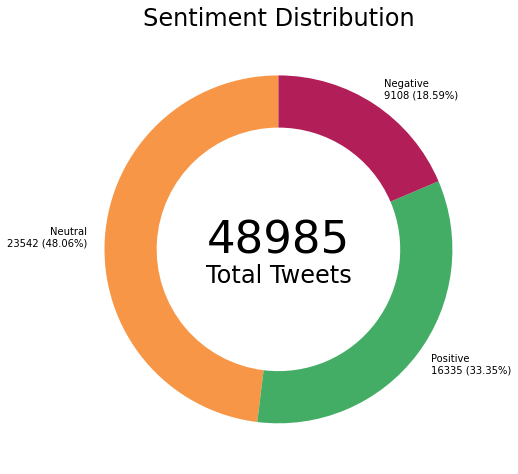

In [11]:
def plot_pie(data):
    pie_data = data.value_counts()
    color_mapper = {"positive" : "#43AD65", "neutral" : "#F79647", "negative" : "#B21E58"}
    labels = [(f"{pie_data.index[i].title()}\n{pie_data.values[i]}"+
               f" ({round(pie_data.values[i] / sum(pie_data.values) * 100, 2)}%)") 
              for i in range(len(pie_data.values))]
    
    plt.figure(figsize=(8, 8))
    plt.pie(pie_data.values,
            labels = labels,
            colors=[color_mapper[x.lower()] for x in pie_data.index],
            wedgeprops={'width':0.3}, 
            startangle=90)

    plt.title("Sentiment Distribution", fontsize=24)
    plt.text(0, 0.05, sum(pie_data.values), ha='center', va='center', fontsize=45)
    plt.text(0, -0.15, "Total Tweets", ha='center', va='center', fontsize=24)
    plt.show()


plot_pie(data_full["prediction"])

**Insight**

Dapat dilihat dari pie chart di atas bahwa pada rentang waktu 20 - 26 April 2020 jumlah tweet masyarakat DKI Jakarta dengan topik COVID-19 yang bermuatan positif jauh lebih banyak dari tweet yang bermuatan negatif sedangkan tweet yang bermuatan netral jauh melampaui keduanya.

**Tweet perhari Berdasarkan Sentimen**

Akan dilihat perbandingan tweet perharinya dari tanggal 20 - 26 April 2020 berdasarkan sentimennya

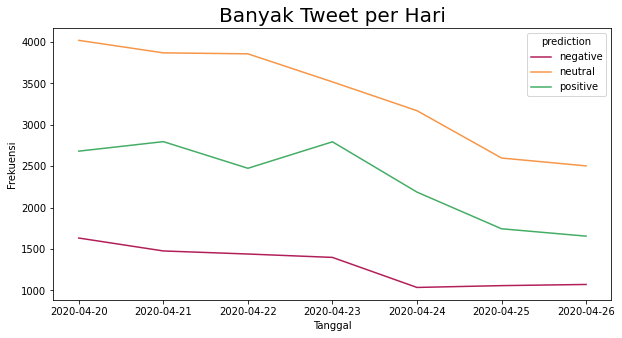

In [12]:
tph = data_full["tweets"].groupby([data_full["tanggal"].dt.date, data_full["prediction"]]).count()
tph = tph.reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(x="tanggal", y="tweets", hue="prediction", data=tph, palette=color_mapper)
plt.title("Banyak Tweet per Hari", fontsize=20)
plt.xlabel("Tanggal")
plt.ylabel("Frekuensi")
plt.show()

**Insight**

Dapat dilihat dari diagram garis di atas bahwa pada rentang 20 - 26 April 2020 jumlah tweet masyarakat DKI Jakarta dengan topik COVID-19 yang bermuatan netral jauh lebih banyak dan di susul oleh tweet yang bermuatan positif lalu tweet yang bermuatan netagtif. Dapat dilihat juga bahwa grafik menunjukan penurunan yang berarti pembahasan topik COVID-19 cukup menurun di setiap harinya.

## Penutup

Telah dilakukan Analisis Sentimen dan juga pemodelan terhadapa data hasil crawling. Data dipreprocess dan dilakukan vectorization menggunakan TF-IDF lalu dilakukan pemodelan. Dari berbagai model yang di uji didapatkan `SVM` adalah model dengan performa terbaik.

**Hal yang Dapat Dikembangkan**

1. Memperbanyak jumlah data yang dilakukan labeling secara manual
2. Menggunakan Boosting dalam pemodelan seperti, XGBoost, CatBoost, LGBM, dst.
3. Menggunakan metode Deep Learning

In [13]:
####################
## Saving Objects ##
####################

os.makedirs("../output", exist_ok=True)

# Export data baru
data.to_csv("../output/Data Sentiment Twitter 20 - 22 April.csv", index=False)

# Saving Model
pickle.dump(
    pipe, 
    open(f"../output/[TRAINED] Model_{datetime.today().strftime('%Y-%m-%d')}.pickle", "wb")
)